--- Generating Advanced Weather Report ---
Harmonic Model Fitted: Base Temp 1.2°C, Daily Swing ±1.4°C
Data report saved to: weather_report_data.csv
Visual report saved to: advanced_projection_report.png


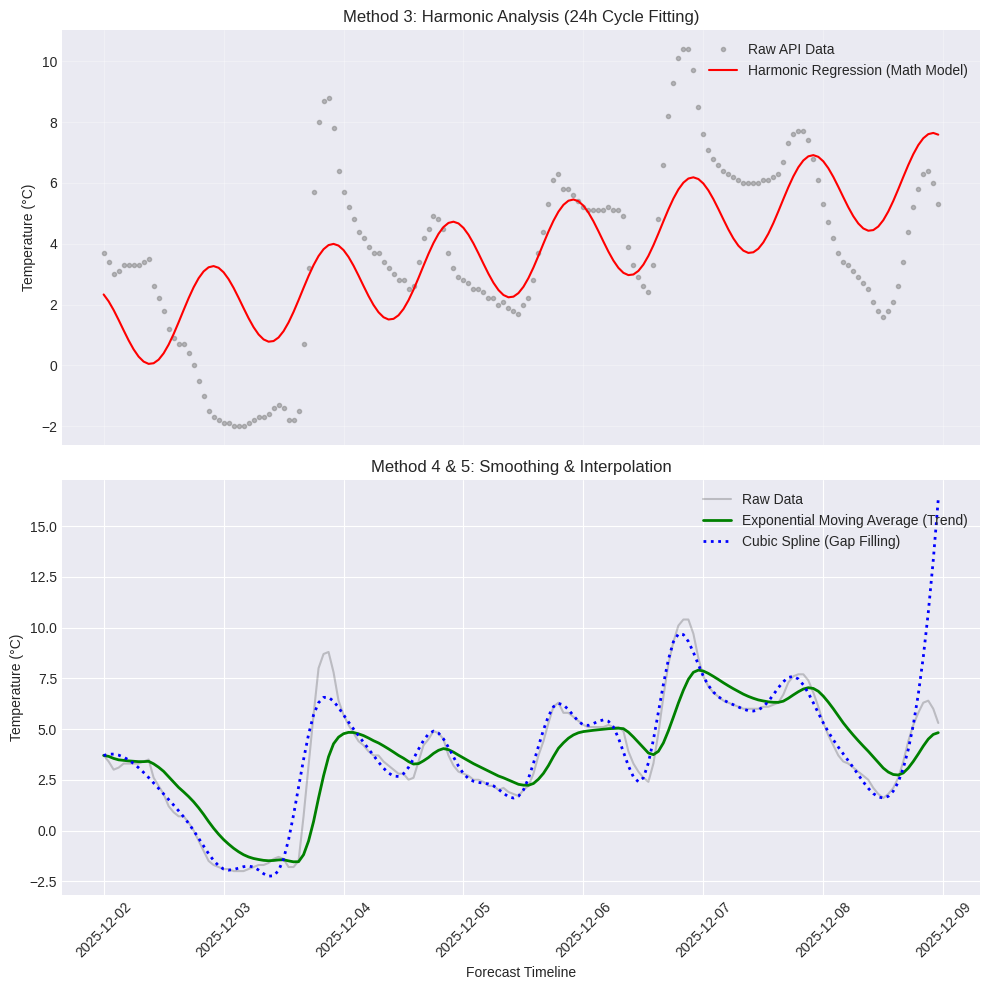

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
import os

LATITUDE = 36.17
LONGITUDE = -86.78
FORECAST_DAYS = 7

print("--- Generating Advanced Weather Report ---")

url = (
    f"https://api.open-meteo.com/v1/forecast?"
    f"latitude={LATITUDE}&longitude={LONGITUDE}"
    f"&hourly=temperature_2m"
    f"&forecast_days={FORECAST_DAYS}"
    f"&temperature_unit=celsius"
)

response = requests.get(url)
data = response.json()
hourly = data['hourly']

df = pd.DataFrame({
    'time': pd.to_datetime(hourly['time']),
    'temperature': hourly['temperature_2m']
})

df['hours_from_start'] = (df['time'] - df['time'].iloc[0]).dt.total_seconds() / 3600

def harmonic_weather_model(t, mean_temp, amplitude, phase, trend):
    return mean_temp + amplitude * np.sin(2 * np.pi * t / 24 + phase) + trend * t

initial_guesses = [df['temperature'].mean(), 5, 0, 0]
params, _ = curve_fit(harmonic_weather_model, df['hours_from_start'], df['temperature'], p0=initial_guesses)
df['proj_harmonic'] = harmonic_weather_model(df['hours_from_start'], *params)

print(f"Harmonic Model Fitted: Base Temp {params[0]:.1f}°C, Daily Swing ±{abs(params[1]):.1f}°C")

df['proj_ema'] = df['temperature'].ewm(span=12, adjust=False).mean()

sparse_indices = np.arange(0, len(df), 6)
sparse_df = df.iloc[sparse_indices]
spline_model = CubicSpline(sparse_df['hours_from_start'], sparse_df['temperature'])
df['proj_spline'] = spline_model(df['hours_from_start'])

csv_filename = "weather_report_data.csv"
df.to_csv(csv_filename, index=False)
print(f"Data report saved to: {csv_filename}")

plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ax1.plot(df['time'], df['temperature'], 'o', markersize=3, label='Raw API Data', color='gray', alpha=0.5)
ax1.plot(df['time'], df['proj_harmonic'], 'r-', linewidth=1.5, label='Harmonic Regression (Math Model)')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Method 3: Harmonic Analysis (24h Cycle Fitting)', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

ax2.plot(df['time'], df['temperature'], 'k-', alpha=0.2, label='Raw Data')
ax2.plot(df['time'], df['proj_ema'], 'g-', linewidth=2, label='Exponential Moving Average (Trend)')
ax2.plot(df['time'], df['proj_spline'], 'b:', linewidth=2, label='Cubic Spline (Gap Filling)')
ax2.set_ylabel('Temperature (°C)')
ax2.set_xlabel('Forecast Timeline')
ax2.set_title('Method 4 & 5: Smoothing & Interpolation', fontsize=12)
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.tight_layout()

img_filename = "advanced_projection_report.png"
plt.savefig(img_filename)
print(f"Visual report saved to: {img_filename}")
plt.show()
